# Lifetime prediction



## Introduction

We search for answer for a question: will my campaign achieve positive ROI in next N days?

### Approach

1 Find what function is the best for campaing revenue

2 Apply function on each campaign and predict future revenue

3 Say if revene on given day is higher or lower than costs



## Functions

In [32]:
%pylab inline 

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from sklearn.metrics import r2_score, explained_variance_score

def f_linear(x, a, b):
    return a * x + b 

def f_power(x, a, b):
    return a * x**b

def f_poly2(x, a, b, c):
    return a * pow(x,2) + b * x + c

def f_exp(x, a, b, c):
    return a*np.exp(b*x)+c

def f_sigmoid(x, a, b):
    return a/(1+np.exp(-b*x))

def func(x, a, b, c):
    return a * x * x + b * x + c
    #    return a * np.exp(-b * x) + c

def fit_exp_linear(x, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(x, y, 1)
    A = np.exp(A_log)
    return A, K

def fit_data(x, y):
    funs_2p = ['f_sigmoid', 'f_linear', 'f_power']
    funs_3p = []#['f_poly2']
    scores = []
    for fn in funs_2p:
        scores.append(fit_fn(x, y, fn, (1, 1e-2)))
    for fn in funs_3p:
        scores.append(fit_fn(x, y, fn, (1, 1, 1)))    
    return scores

def fit_fn(x,y,fn, default = None):
    if default is None:
        popt, pcov = curve_fit( getattr(sys.modules[__name__], "%s" % fn), x, y)
    else:
        popt, pcov = curve_fit( getattr(sys.modules[__name__], "%s" % fn), x, y, p0 = default)

    yn = getattr(sys.modules[__name__], "%s" % fn)(x, *popt)
    score = explained_variance_score(y,yn)
    
#     plt.figure()
#     plt.plot(x, y, 'ko', label="Original Data")
#     plt.plot(x, yn, 'r-', label="Curve "+fn+ " explained " + "%.2f" % (score*100) + "%")
#     plt.legend()
    return {"r2": score, "coefs": popt, "function": fn}


Populating the interactive namespace from numpy and matplotlib


## Input parameters

In [33]:
campaigns = [
    {"name": "c1", "costs": 55, "revenue": [12,10,5,1,2,3,4,5,4,3,2,1,7,4,3]},
    {"name": "c2", "costs": 56, "revenue": [10,5,4]},
    {"name": "c3", "costs": 57, "revenue": [11,10,5,1,2,3,4,5,4,3,2,1]},
    {"name": "c4", "costs": 58, "revenue": [10,5,1,2,3,4,5,4,3,2,1]},
    {"name": "c5", "costs": 57, "revenue": [5,4,2]}
]

expected_days = 30
predict_days = 60


## Find the best function for all campaigns 

The best fit has f_power curve with R^2 = 0.88


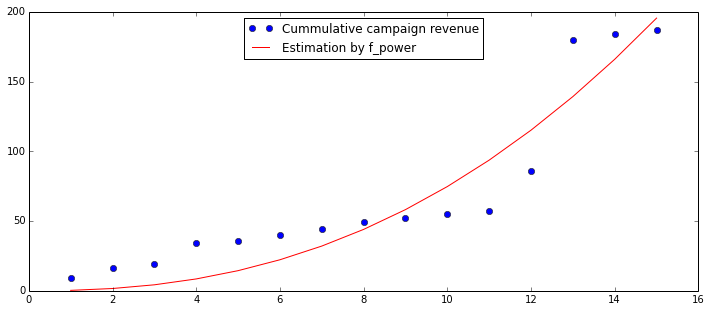

In [37]:
days_revenue = np.array([0 for i in xrange(max( [len(c['revenue']) for c in campaigns]))])
days_counts = np.array([0 for i in xrange(len(days_revenue))])
days_index = np.array([i+1 for i in xrange(len(days_revenue))])

for c in campaigns:
    for i, dr in enumerate(c.get('revenue')):
        days_revenue[i]+=dr
        days_counts[i]+=1
avg_days_revenue = days_revenue.cumsum() / days_counts

x = days_index
y = avg_days_revenue

scores = fit_data(x,y)
best = sorted(scores, key=lambda x: x['r2'], reverse=True)[0]
print "The best fit has %s curve with R^2 = %.2f" % ( best['function'], best['r2'] )

y_est = getattr(sys.modules[__name__], "%s" % best['function'])(x, *best['coefs'])

plt.figure()
plt.plot(x, y, 'bo', label="Cummulative campaign revenue")
plt.plot(x, y_est, 'r-', label="Estimation by " + best['function'])
plt.legend(loc='upper center')
plt.rcParams["figure.figsize"] = [12,5]
plt.show()

Predicted cumulative campaign revenue on 30th day is 1093.84.


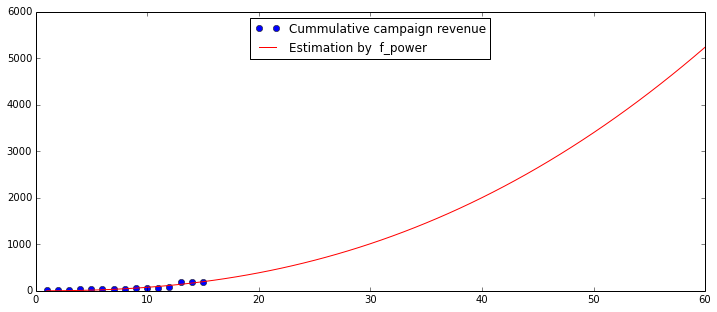

In [38]:
xx = np.array([i+1 for i in xrange(predict_days)])
yy_est = getattr(sys.modules[__name__], "%s" % best['function'])(xx, *best['coefs'])

plt.figure()
plt.rcParams["figure.figsize"] = [12,5]
plt.plot(x, y, 'bo', label="Cummulative campaign revenue")
plt.plot(xx, yy_est, 'r-', label="Estimation by  " + best['function'])
plt.legend(loc='upper center')

print "Predicted cumulative campaign revenue on %dth day is %.2f." % (expected_days, yy_est[expected_days])

## Fit campaigns

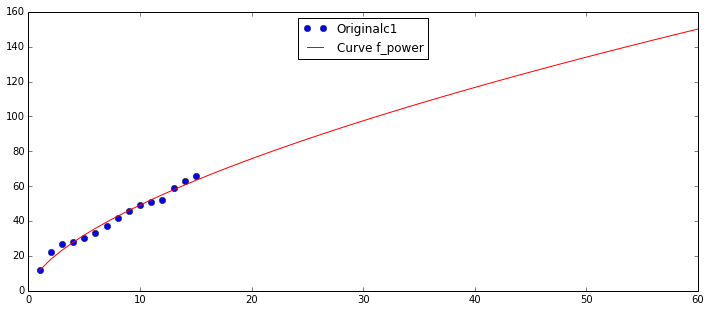

Predicted revenue for campaign c1 on 30th day is 99.51€ and costs were 55.00€


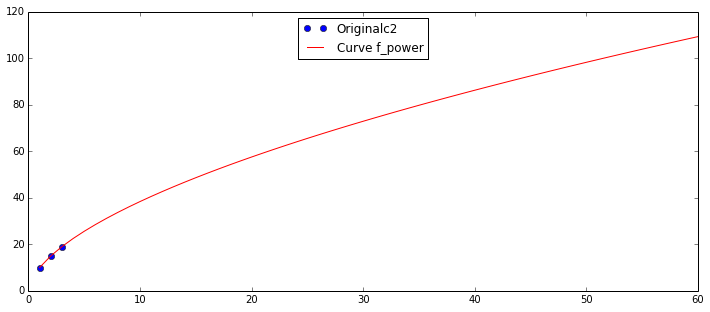

Predicted revenue for campaign c2 on 30th day is 74.34€ and costs were 56.00€


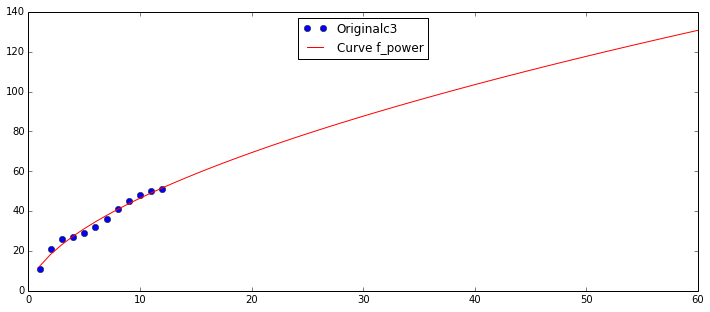

Predicted revenue for campaign c3 on 30th day is 89.30€ and costs were 57.00€


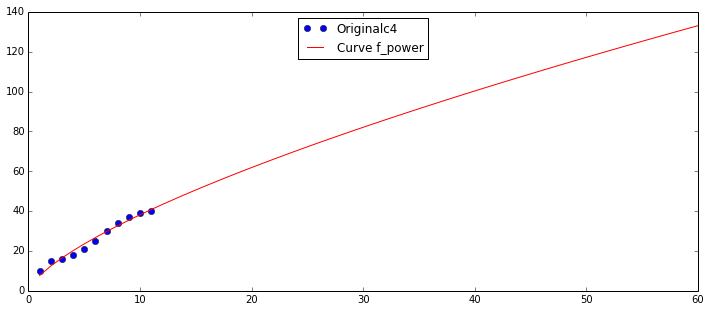

Predicted revenue for campaign c4 on 30th day is 83.96€ and costs were 58.00€


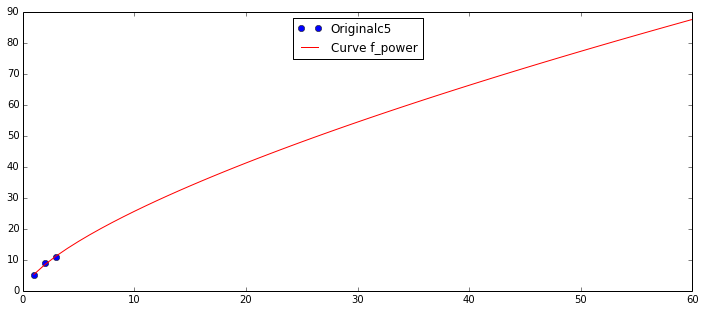

Predicted revenue for campaign c5 on 30th day is 55.67€ and costs were 57.00€


In [39]:
for c in campaigns:
    y = np.array(c['revenue']).cumsum()
    x = np.array([i+1 for i in xrange(len(y))])

    score = fit_fn(x,y, best['function'])
    y_est = getattr(sys.modules[__name__], "%s" % score['function'])(x, *score['coefs'])
    yy_est = getattr(sys.modules[__name__], "%s" % score['function'])(xx, *score['coefs'])

    plt.figure()
    plt.rcParams["figure.figsize"] = [12,5]
    plt.plot(x, y, 'bo', label="Original" + c['name'])
    plt.plot(xx, yy_est, 'r-', label="Curve " + score['function'])
    plt.legend(loc='upper center')
    plt.show()
    
    print "Predicted revenue for campaign %s on %dth day is %.2f€ and costs were %.2f€" % (
        c['name'],expected_days, yy_est[expected_days], c['costs'])
    
